# Focus on what matters: inferring low-dimensional dynamics from neural recordings

**By Neuromatch Academy**

__Content creators:__ Marius Pachitariu, Pedram Mouseli, Lucas Tavares, Jonny Coutinho,
Blessing Itoro, Gaurang Mahajan, Rishika Mohanta

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective:
It is very difficult to interpret the activity of single neurons in the brain, because their firing patterns are noisy, and it is not clear how a single neuron can contribute to cognition and behavior. However, neurons in the brain participate in local, regional and brainwide dynamics. No neuron is isolated from these dynamics, and much of a single neuron's activity can be predicted from the dynamics. Furthermore, only populations of neurons as a whole can control cognition and behavior. Hence it is crucial to identify these dynamical patterns and relate them to stimuli or behaviors.

In this notebook, we generate simulated data from a low-dimensional dynamical system and then use seq-to-seq methods to predict one subset of neurons from another. This allows us to identify the low-dimensional dynamics that are sufficient to explain the activity of neurons in the simulation. The methods described in this notebook can be applied to large-scale neural recordings of hundreds to tens of thousans of neurons, such as the ones from the NMA-CN course.

---
# Setup

In [1]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Note:** If `cuda` is not enabled, go to `Runtime`--> `Change runtime type` and in `Hardware acceleration` choose `GPU`.

---
#  Define RNN

In [4]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

In [5]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [6]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [7]:
alldat[0].keys()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

In [16]:
indices_regions=alldat[0]['brain_area']==['VISp' or 'MOp' or 'MOs']

In [17]:
alldat[0]["mouse_name"]

'Cori'

In [18]:
alldat[0]["brain_area"].shape

(734,)

#Sessions with data for both areas VISp and MOs

In [8]:
# initialize a list to hold the indices of sessions with both 'VISp' and 'MOs' data
sessions_with_both = []

# iterate over each dictionary in the alldat array
for i, data_dict in enumerate(alldat):
    # check if both 'VISp' and 'MOs' are in the brain_area data for this session
    if 'VISp' in data_dict['brain_area'] and 'MOs' in data_dict['brain_area']:
        # if both are present, add the index of this session to the list
        sessions_with_both.append(i)

# print the indices of sessions with both 'VISp' and 'MOs' data
print(sessions_with_both)


[0, 3, 7, 11, 13, 21, 24, 25, 38]


In [20]:
# shapes of visp and mos for different sessions
ali=np.empty(None,None,None)
indices_regions_visp_24=alldat[24]['brain_area']==['VISp']
indices_regions_mos_24=alldat[24]['brain_area']==['MOs']
for i in sessions_with_both:
  indices_regions_VISp=alldat[i]['brain_area']==['VISp']
  indices_regions_MOs=alldat[i]['brain_area']==['MOs']
  print(f"{i} {alldat[i]['spks'][indices_regions_VISp].shape} {alldat[i]['spks'][indices_regions_MOs].shape}")
  # print(alldat[i]["spks"][indices_regions_VISp].shape)
  #np.concatenate(ali,alldat[i]['spks'][indices_regions_VISp][:,:178,:])

0 (178, 214, 250) (113, 214, 250)
3 (39, 249, 250) (92, 249, 250)
7 (48, 250, 250) (112, 250, 250)
11 (66, 340, 250) (6, 340, 250)
13 (42, 268, 250) (186, 268, 250)
21 (133, 444, 250) (65, 444, 250)
24 (94, 261, 250) (80, 261, 250)
25 (162, 178, 250) (166, 178, 250)
38 (15, 343, 250) (54, 343, 250)


<ipython-input-20-703b16968264>:2: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  ali=np.empty(None,None,None)


# Creating Dataset session#0

In [9]:

# indices_regions=alldat[0]['brain_area']==['VISp' or 'MOp' or 'MOs']
# corri_session0=alldat[0]["spks"][indices_regions]
# cori_data_axis_change = np.transpose(corri_session0, axes=(2, 1, 0))
indices_regions_visp=alldat[0]['brain_area']==['VISp']
indices_regions_mos=alldat[0]['brain_area']==['MOs']

corri_session0_visp=alldat[0]["spks"][indices_regions_visp]
corri_session0_mos=alldat[0]["spks"][indices_regions_mos]

cori_data_axis_change_visp = np.transpose(corri_session0_visp, axes=(2, 1, 0))
cori_data_axis_change_mos = np.transpose(corri_session0_mos, axes=(2, 1, 0))

In [22]:
cori_data_axis_change_mos.shape

(250, 214, 113)

In [23]:
cori_data_axis_change_visp.shape

(250, 214, 178)

In [24]:
alldat[0]["spks"].shape

(734, 214, 250)

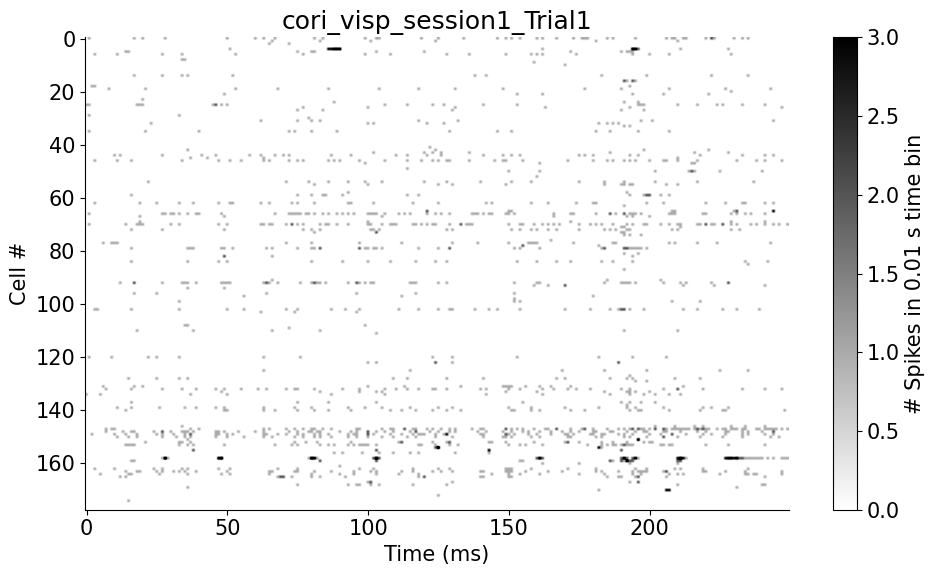

In [25]:
plt.figure(figsize = (10, 6))
plt.imshow(cori_data_axis_change_visp[:, 1, :].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('cori_visp_session1_Trial1')
plt.show()

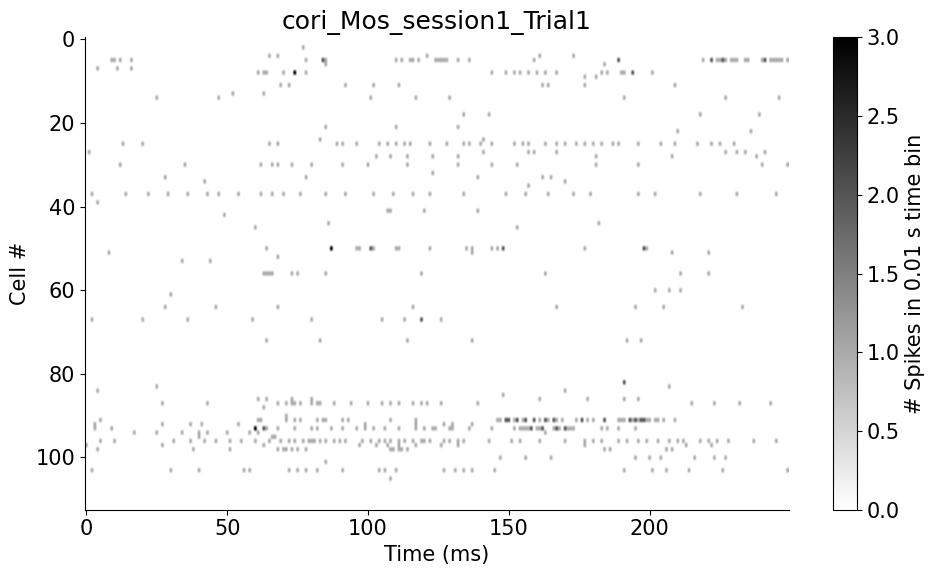

In [26]:
plt.figure(figsize = (10, 6))
plt.imshow(cori_data_axis_change_mos[:, 1, :].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('cori_Mos_session1_Trial1')
plt.show()

---
# Plot and Prepare data: Training Data
Trials: 150

In [10]:
ncomp=10
# Assume area1_data and area2_data are your datasets for the two brain areas
# They should be 3D arrays with dimensions (time, trials, neurons)

# Convert data to PyTorch tensors
x1 = torch.from_numpy(cori_data_axis_change_visp[:, :150, :]).to(device).float()
x0 = torch.from_numpy(cori_data_axis_change_mos[:, :150, :]).to(device).float()  # output data from area 2


NN1 = x1.shape[-1]  # number of neurons in input data
NN2 = x0.shape[-1]  # number of neurons in output data

# Initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# Set the biases of the last layer as the mean firing rates of the neurons in output data
net.fc.bias.data[:] = x0.mean((0,1))

# Set up the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

niter = 1000

def Poisson_loss(lam, spk):
    return lam - spk * torch.log(lam)


# Training loop
for k in range(niter):
    # Forward pass
    z, _ = net(x1)

    # Calculate cost
    cost = Poisson_loss(z, x0).mean()

    # Backward pass and optimization
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

    if k % 100 == 0:
        print(f'iteration {k}, cost {cost.item():.4f}')


iteration 0, cost 0.1421
iteration 100, cost 0.0578


KeyboardInterrupt: ignored

# Validation Set

Trials: 150 to 182

In [12]:
# we separate the neuron data into two populations: the input and output
x1_val = torch.from_numpy(cori_data_axis_change_visp[:, 150:182, :]).to(device).float()
x0_val = torch.from_numpy(cori_data_axis_change_mos[:, 150:182, :]).to(device).float()

#Train with validation set

In [11]:
ncomp=10
# Assume area1_data and area2_data are your datasets for the two brain areas
# They should be 3D arrays with dimensions (time, trials, neurons)

# Convert data to PyTorch tensors
x1_train = torch.from_numpy(cori_data_axis_change_visp[:, :150, :]).to(device).float()
x0_train = torch.from_numpy(cori_data_axis_change_mos[:, :150, :]).to(device).float()  # output data from area 2


NN1 = x1_train.shape[-1]  # number of neurons in input data
NN2 = x0_train.shape[-1]  # number of neurons in output data

def Poisson_loss(lam, spk):
    return lam - spk * torch.log(lam)


In [13]:
# Initialize the neural network
net = Net(ncomp, NN1, NN2, bidi=True).to(device)

# Set the biases of the last layer as the mean firing rates of the neurons in the training output data
net.fc.bias.data[:] = x0_train.mean((0,1))

# Set up the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

# Define the number of iterations
niter = 1000
train_costs = []
val_costs = []

# Training loop
for k in range(niter):
    # Forward pass on training data
    z_train, _ = net(x1_train)

    # Calculate cost on training data
    cost_train = Poisson_loss(z_train, x0_train).mean()

    # Backward pass and optimization
    cost_train.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Validation
    if k % 100 == 0:
        # Forward pass on validation data
        z_val, _ = net(x1_val)

        # Calculate cost on validation data
        cost_val = Poisson_loss(z_val, x0_val).mean()

        print(f'iteration {k}, train cost {cost_train.item():.4f}, validation cost {cost_val.item():.4f}')


iteration 0, train cost 0.1518, validation cost 0.1485
iteration 100, train cost 0.0583, validation cost 0.0727
iteration 200, train cost 0.0565, validation cost 0.0713
iteration 300, train cost 0.0558, validation cost 0.0712
iteration 400, train cost 0.0553, validation cost 0.0713
iteration 500, train cost 0.0549, validation cost 0.0716
iteration 600, train cost 0.0547, validation cost 0.0719
iteration 700, train cost 0.0554, validation cost 0.0715
iteration 800, train cost 0.0550, validation cost 0.0716
iteration 900, train cost 0.0548, validation cost 0.0716


In [38]:
z_train_array = z_train.detach().cpu().numpy()


In [39]:
x0_train_array = x0_train.detach().cpu().numpy()

In [40]:
x0_train_array.shape

(250, 150, 113)

In [14]:
# we separate the neuron data into two populations: the input and output
x1_test = torch.from_numpy(cori_data_axis_change_visp[:, 182:, :]).to(device).float()
x0_test = torch.from_numpy(cori_data_axis_change_mos[:, 182:, :]).to(device).float()

# Test the RNN

In [15]:
# the network outputs the single-neuron prediction and the latents
z_test, y_test = net(x1_test)

# our log-likelihood cost
cost_test = Poisson_loss(z_test, x0_test).mean()

print(f'test cost {cost_test.item():.4f}')


test cost 0.0869


---
# Compare true firing rates with the predicted.

Note that for real data we only get the spikes, not the true firing rates!

In [16]:
prediction_test = z_test.detach().cpu().numpy()


In [33]:
actual_test = x0_test.detach().cpu().numpy()


In [18]:
spike_counts = np.random.poisson(prediction_test)

In [19]:
print(spike_counts.shape)  # Prints the shape of the array
#print(rpred.size)   # Prints the total number of elements in the array


(250, 32, 113)


In [ ]:
#Print for neuron 1 and trial 1
print(spike_counts[:, 0, 0])
print(actual_test[:, 0, 0])

In [ ]:
#Summing of spikes for all trials at each time bin. Neuron is 1.
spike_count_actual = np.sum(spike_counts[:, :, 0], axis=1) #actual data
spike_count_pred = np.sum(actual_test[:, :, 0], axis=1) #predicted data
print(spike_count_actual) # actual spike count for each time bin
print(spike_count_pred) # predicted spike count for each time bin

In [ ]:
#Summing of spikes for all trials at each time bin. Neuron is 1.
actual_test_rate_29 = (np.sum(spike_counts[:, :, 29], axis=1))/32 #actual data
print(actual_test_rate_29) # actual spike rate
print(prediction_test[:,0, 29]) # predicted spike rate

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

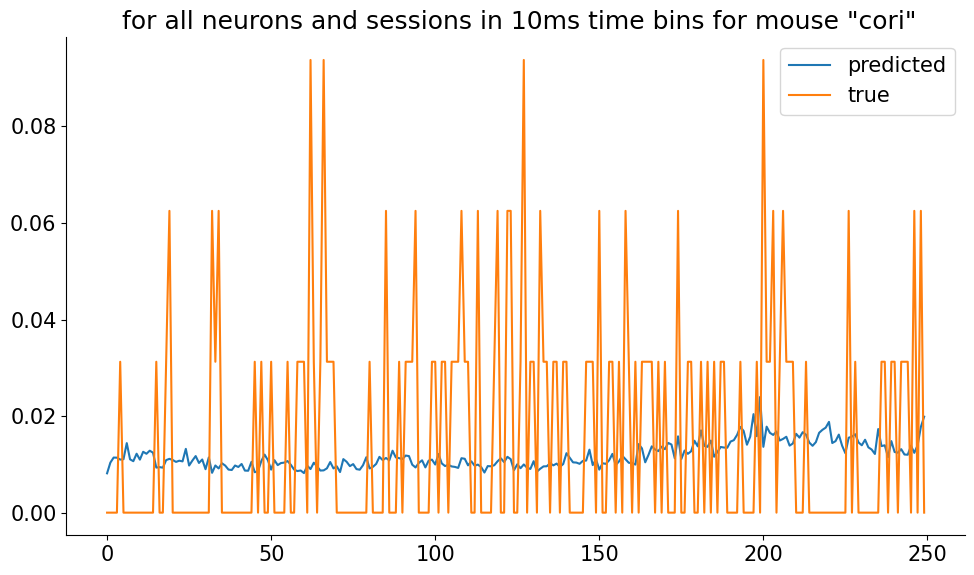

In [34]:
import torch

actual_test_mean_trials=np.mean(actual_test,axis=1)
actual_test_mean_trials_neurons=np.mean(actual_test_mean_trials,axis=1)


prediction_test_mean_trials=np.mean(prediction_test,axis=1)
prediction_test_mean_trials_neurons=np.mean(prediction_test_mean_trials,axis=1)

#rpred_new=np.mean(rpred_new,axis=1)
# x0=x0.cpu().numpy()
# x0_mean=np.mean(x0,axis=1)
# x0_mean=np.mean(x0_mean,axis=1)
#nn = 30
plt.figure(figsize=(10, 6))
plt.plot(prediction_test_mean_trials[:, 100])
plt.plot(actual_test_mean_trials[:,100])
#plt.plot(rpred_new)
plt.legend(['predicted','true'])
plt.title(' for all neurons and sessions in 10ms time bins for mouse "cori"')
plt.plot


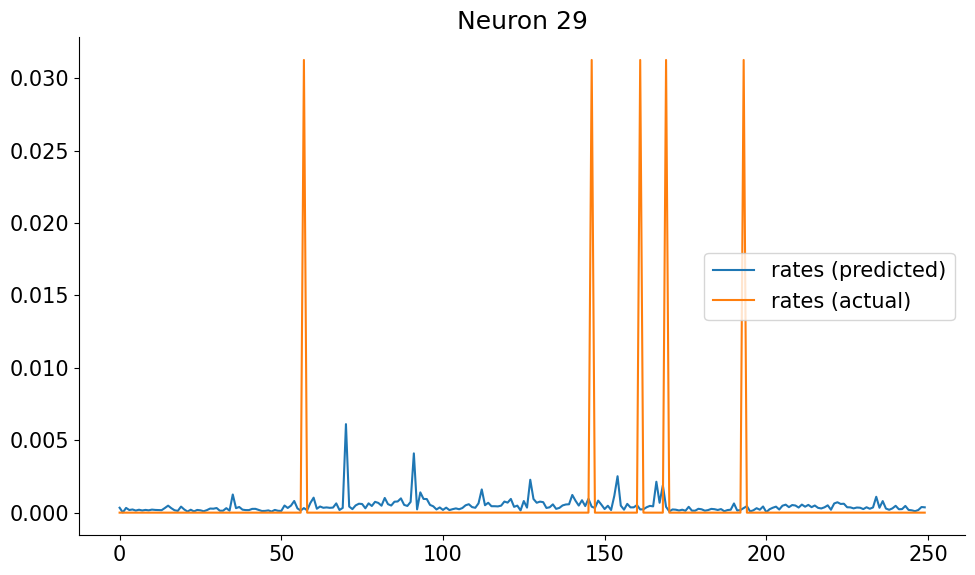

In [37]:
#nn=29
plt.figure(figsize=(10, 6))
#plt.plot(spike_mean_actual)
#plt.plot(spike_mean_pred)
#plt.plot(rates[:,0, 0])
plt.plot(prediction_test[:,0, 29])
plt.plot(actual_test_rate_29)
#plt.plot(-.5 + x[:, nn, 0]/4)

plt.legend(['rates (predicted)', 'rates (actual)'])
plt.title(f'Neuron 29')
plt.show()

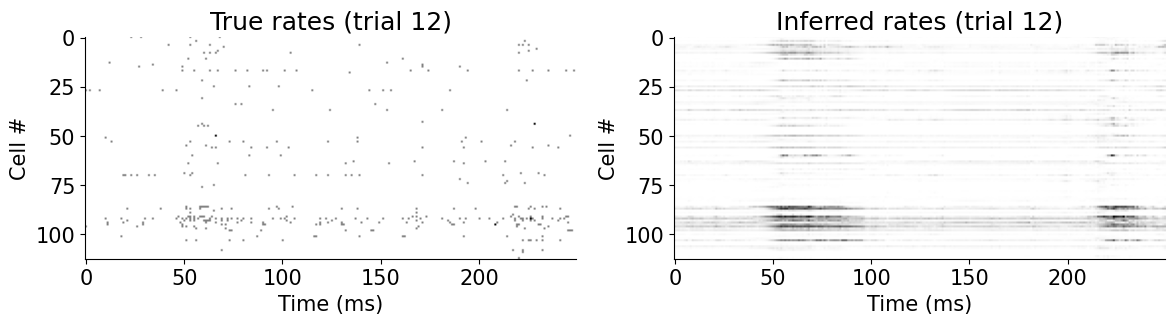

In [36]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(actual_test[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('True rates (trial 12)')

plt.subplot(122)
plt.imshow(prediction_test[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('Inferred rates (trial 12)')
plt.show()

In [35]:
# Select data for the first neuron across all trials
neuron_data = rpred[:, :, 0]

# Assume each timebin corresponds to 1 millisecond
timebin_duration = 1e-2  # duration of a timebin in seconds

# Initialize array to store firing rates for each timebin
firing_rates = np.zeros(neuron_data.shape[0])

# Calculate firing rate for each timebin
for i in range(neuron_data.shape[0]):
    # Calculate total number of spikes in the current timebin
    total_spikes = np.sum(neuron_data[i])

    # Calculate firing rate (in Hz) and store it
    firing_rates[i] = total_spikes / (timebin_duration * neuron_data.shape[1])  # number of trials is neuron_data.shape[1]

# Now firing_rates[i] holds the firing rate for the i-th timebin


In [36]:
# Select data for the first neuron across all trials
neuron_data_actual = x0_test_array[:, :, 0]

# Assume each timebin corresponds to 1 millisecond
timebin_duration = 1e-2  # duration of a timebin in seconds

# Initialize array to store firing rates for each timebin
firing_rates_actual = np.zeros(neuron_data_actual.shape[0])

# Calculate firing rate for each timebin
for i in range(neuron_data_actual.shape[0]):
    # Calculate total number of spikes in the current timebin
    total_spikes = np.sum(neuron_data_actual[i])

    # Calculate firing rate (in Hz) and store it
    firing_rates_actual[i] = total_spikes / (timebin_duration * neuron_data_actual.shape[1])  # number of trials is neuron_data.shape[1]

# Now firing_rates[i] holds the firing rate for the i-th timebin


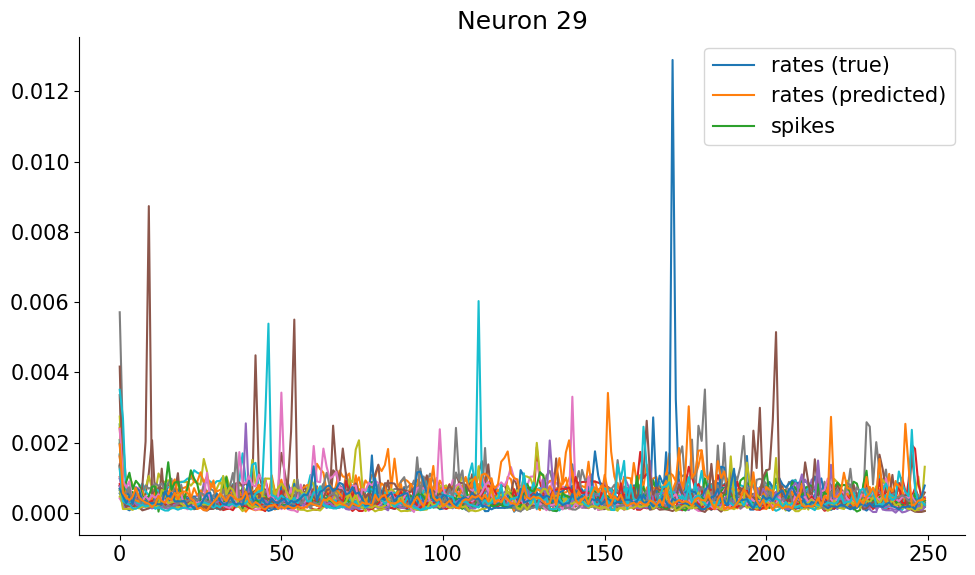

In [27]:
nn = 29
plt.figure(figsize=(10, 6))
#plt.plot(rates[:,nn, 0])
plt.plot(rpred[:,:, nn])
#plt.plot(-.5 + x[:, nn, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {nn}')
plt.show()

## View firing rates for all neurons in one trial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def leaky_integrate_and_fire(spike_counts, time_bin_duration, threshold, capacitance, resistance, leak_resistance):
    # Convert spike counts to current
    current = spike_counts / time_bin_duration

    # Initialize variables
    voltage = 0.0
    waveform = []

    for i in range(len(current)):
        # Integrate voltage using LIF circuit equation
        dv_dt = (current[i] - voltage / resistance - (voltage / leak_resistance)) / capacitance
        voltage += dv_dt * time_bin_duration

        # Check if voltage crosses the threshold
        if voltage >= threshold:
            waveform.append(1)  # Spike occurred
            voltage = 0.0      # Reset voltage after spike
        else:
            waveform.append(0)  # No spike

    return waveform

# Example usage
cori_data_axis_change[:,0, 40]  # Spike counts in each time bin
time_bin_duration = 0.01  # Time bin duration in seconds
threshold = 1.0          # Voltage threshold for generating a spike
capacitance = 1.0        # Capacitance value in Farads
resistance = 1.0         # Resistance value in Ohms
leak_resistance = 0.5    # Leak resistance value in Ohms

waveform = leaky_integrate_and_fire(spike_counts, time_bin_duration, threshold, capacitance, resistance, leak_resistance)

# Plot the waveform
time = np.arange(len(waveform)) * time_bin_duration
plt.plot(time, waveform)
plt.xlabel('Time (s)')
plt.ylabel('Spike')
plt.title('Leaky Integrate-and-Fire Waveform')
plt.show()

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(cori_data_axis_change[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('True rates (trial 12)')

plt.subplot(122)
plt.imshow(rpred[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('Inferred rates (trial 12)')
plt.show()

---
# Visualize the latent dynamics

In [ ]:
ycpu = y.detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, 0, :]);
plt.title('All latents on trial 0')

plt.subplot(122)
plt.plot(ycpu[:, :, 0]);
plt.title('All trials for latent 0')
plt.show()

Not much to see for the latents. This is not surprising, since we generated them with random data, so they look just like a random walk process.

Now apply this model on real data and see if you can interpret the latents.



**For Testing the code**

Use grid-search to find the best hyperparameters

# Changes

ncomp = 15
nonlinearity = relu

In [ ]:
ncomp=15
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout=0,
                      bidirectional = bidi, nonlinearity = 'relu')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

In [ ]:
cori_data_axis_change_mos[:, :, :].shape

(250, 214, 113)

In [ ]:
# we separate the neuron data into two populations: the input and output
x_input = torch.from_numpy(cori_data_axis_change_visp[:, :, :]).to(device).float()
y_real = torch.from_numpy(cori_data_axis_change_mos[:, :, :]).to(device).float()
# x0 = torch.from_numpy(x).to(device).float()
# x1 = torch.from_numpy(y).to(device).float()

shape_Of_output = y_real.shape[-1]
shape_Of_input = x_input.shape[-1]

# we initialize the neural network
net = Net(ncomp, shape_Of_input, shape_Of_output, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = y_real.mean((0,1))
# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.0005)

**# plotting learning curves**

iteration 0, train cost 0.1440, test cost 0.1429
iteration 100, train cost 0.0823, test cost 0.0823
iteration 200, train cost 0.0676, test cost 0.0679
iteration 300, train cost 0.0657, test cost 0.0660
iteration 400, train cost 0.0648, test cost 0.0653
iteration 500, train cost 0.0643, test cost 0.0648
iteration 600, train cost 0.0639, test cost 0.0645
iteration 700, train cost 0.0636, test cost 0.0642
iteration 800, train cost 0.0634, test cost 0.0640
iteration 900, train cost 0.0632, test cost 0.0638
iteration 1000, train cost 0.0630, test cost 0.0637
iteration 1100, train cost 0.0628, test cost 0.0636
iteration 1200, train cost 0.0627, test cost 0.0635
iteration 1300, train cost 0.0625, test cost 0.0634
iteration 1400, train cost 0.0624, test cost 0.0634
iteration 1500, train cost 0.0623, test cost 0.0633
iteration 1600, train cost 0.0621, test cost 0.0633
iteration 1700, train cost 0.0620, test cost 0.0632
iteration 1800, train cost 0.0619, test cost 0.0632
iteration 1900, train co

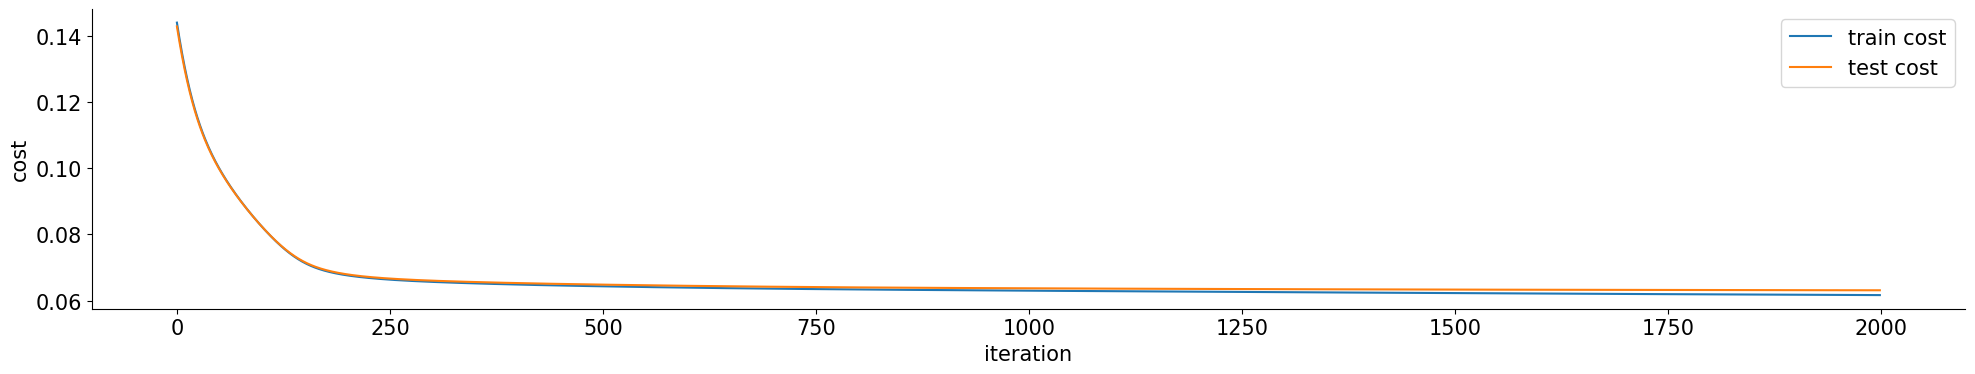

In [ ]:
from sklearn.model_selection import train_test_split

# Define the Poisson log-likelihood loss
def poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)
seed=42
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_input, y_real, test_size=0.2,random_state=seed)

n_iter = 2000
train_costs = []
test_costs = []

for k in range(n_iter):
  # The network outputs the single-neuron prediction and the latents
  z, y = net(x_train)

  # Compute the training cost
  cost = poisson_loss(z, y_train).mean()

  # Compute the test cost
  with torch.no_grad():
    z_test, y_test_pred = net(x_test)
    test_cost = poisson_loss(z_test, y_test).mean()

  # Train the network
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Record the training and test costs
  train_costs.append(cost.item())
  test_costs.append(test_cost.item())

  if k % 100 == 0:
    print(f'iteration {k}, train cost {cost.item():.4f}, test cost {test_cost.item():.4f}')

# Plot the training and test costs
plt.plot(train_costs, label='train cost')
plt.plot(test_costs, label='test cost')
plt.xlabel('iteration')
plt.ylabel('cost')
plt.legend()
plt.show()

#Testing model for session 24

In [ ]:
#Extracting special regions' neurons (VISP-MOS-MOP)
mouse_name=alldat[1]["mouse_name"]
# indices_regions=alldat[0]['brain_area']==['VISp' or 'MOp' or 'MOs']
# corri_session0=alldat[0]["spks"][indices_regions]
# cori_data_axis_change = np.transpose(corri_session0, axes=(2, 1, 0))
indices_regions_visp_24=alldat[24]['brain_area']==['VISp']
indices_regions_mos_24=alldat[24]['brain_area']==['MOs']

session24_visp=alldat[24]["spks"][indices_regions_visp_24]
session24_mos=alldat[24]["spks"][indices_regions_mos_24]

session24_axis_change_visp = np.transpose(session24_visp, axes=(2, 1, 0))
session24_axis_change_mos = np.transpose(session24_mos, axes=(2, 1, 0))

In [ ]:
session24_axis_change_visp.shape

(250, 261, 94)

In [ ]:
session24_axis_change_mos.shape

(250, 261, 80)

In [ ]:
x_test_24.shape

torch.Size([250, 261, 94])

In [ ]:
y_test_24.shape

torch.Size([250, 261, 80])

In [ ]:

x_test_24 = torch.from_numpy(session24_axis_change_visp).float()
y_test_24 = torch.from_numpy(session24_axis_change_mos).float()

z_1, y_1 = net(x_test_24)
test_cost_24 = poisson_loss(z_1, y_test_24).mean()

print(f'test cost {test_cost_24.item():.4f}')


NameError: ignored

#Grid Search for original data
**Apply grid-search**

*Pay attention to the seed to have same chunks of data for train and val for every run

In [ ]:
from sklearn.model_selection import ParameterGrid
n_iter = 2000
# Define the parameter grid
param_grid = {
    'ncomp': [10, 15, 20],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'activation': ['relu', 'tanh']
}

# Generate all combinations parameters
grid = ParameterGrid(param_grid)

best_params = None
best_test_cost = float('inf')

for params in grid:
    ncomp = params['ncomp']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    activation = params['activation']

    class Net(nn.Module):
        def __init__(self, ncomp, NN1, NN2, bidi=True):
            super(Net, self).__init__()

            self.rnn = nn.RNN(NN1, ncomp, num_layers=num_layers, dropout=0,
                              bidirectional=bidi, nonlinearity=activation)
            self.fc = nn.Linear(ncomp, NN2)

        def forward(self, x):
            y = self.rnn(x)[0]

            if self.rnn.bidirectional:
                q = (y[:, :, :ncomp] + y[:, :, ncomp:]) / 2
            else:
                q = y

            z = F.softplus(self.fc(q), 10)

            return z, q

    net = Net(ncomp, shape_Of_input, shape_Of_output, bidi=True).to(device)
    net.fc.bias.data[:] = y_real.mean((0, 1))
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_costs = []
    test_costs = []

    for k in range(n_iter):
        z, y = net(x_train)
        cost = poisson_loss(z, y_train).mean()

        with torch.no_grad():
            z_test, y_test_pred = net(x_test)
            test_cost = poisson_loss(z_test, y_test).mean()

        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_costs.append(cost.item())
        test_costs.append(test_cost.item())

        if k % 100 == 0:
            print(f'iteration {k}, train cost {cost.item():.4f}, test cost {test_cost.item():.4f}')

    if test_cost < best_test_cost:
        best_test_cost = test_cost
        best_params = params

print("Best parameters:")
print(best_params)

iteration 0, train cost 0.1545, test cost 0.1532
iteration 100, train cost 0.0779, test cost 0.0776
iteration 200, train cost 0.0667, test cost 0.0666
iteration 300, train cost 0.0647, test cost 0.0647
iteration 400, train cost 0.0641, test cost 0.0641
iteration 0, train cost 0.1484, test cost 0.1477
iteration 100, train cost 0.0696, test cost 0.0694
iteration 200, train cost 0.0647, test cost 0.0648
iteration 300, train cost 0.0641, test cost 0.0643
iteration 400, train cost 0.0638, test cost 0.0640
iteration 0, train cost 0.1337, test cost 0.1326
iteration 100, train cost 0.0735, test cost 0.0731
iteration 200, train cost 0.0648, test cost 0.0648
iteration 300, train cost 0.0643, test cost 0.0643
iteration 400, train cost 0.0636, test cost 0.0638
iteration 0, train cost 0.1368, test cost 0.1360
iteration 100, train cost 0.0674, test cost 0.0675
iteration 200, train cost 0.0645, test cost 0.0648
iteration 300, train cost 0.0636, test cost 0.0640
iteration 400, train cost 0.0630, test 